# CLASSIFICATION SPOTIFY DATAo


## Data loading and first analysis

The first thing we need to import the main libraries needed, we will import some more when needed.

Then, we need to load the dataset we are going to use and perform a basic data analysis.

As part of this first EDA we will create a new feature which will divide the track_popularity (our target feature) into 2 bins, Not popular (from 0 to 70) and Popular (from 70 to 100).

We will also visualize the target variable distribution and a correlation heatmap of the features.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

In [4]:
# Adjust this path as necessary
path_to_file='Spotify_songs 2024.xlsx'

# Load data
file_path = path_to_file
spotify_data = pd.read_excel(file_path, sheet_name='spotify songs')
spotify_data.head()


,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2000,Yellow,91,Parachutes,Coldplay,['permanent wave'; 'pop'],86,0.429,0.661,11.0,85.0,1.0,0.0281,0.00239,0.000121,0.2340,0.285,173.372,266773.0
1,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.01030,0.000000,0.6120,0.684,148.726,167067.0
2,2000,Breathe,69,Breathe,Faith Hill,['contemporary country'; 'country'; 'country d...,61,0.529,0.496,7.0,95.0,1.0,0.0290,0.17300,0.000000,0.2510,0.278,136.859,250547.0
3,2000,In the End,88,Hybrid Theory (Bonus Edition),Linkin Park,['alternative metal'; 'nu metal'; 'post-grunge...,83,0.556,0.864,3.0,76.0,0.0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,216880.0
4,2000,Bye Bye Bye,74,No Strings Attached,*NSYNC,['boy band'; 'dance pop'; 'pop'],65,0.610,0.926,8.0,68.0,0.0,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400.0


C:\Users\Marta Lacasta\AppData\Local\Temp\ipykernel_20980\3760737673.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


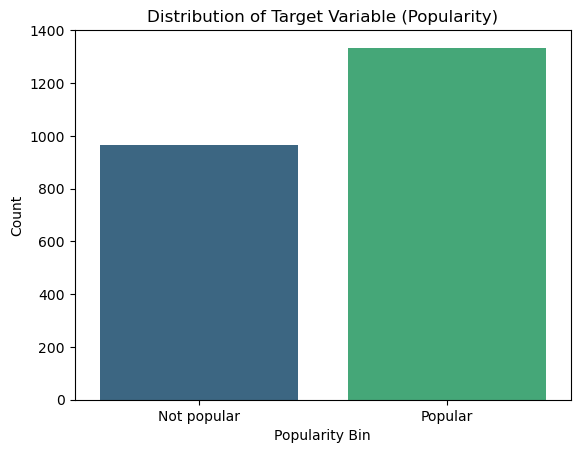

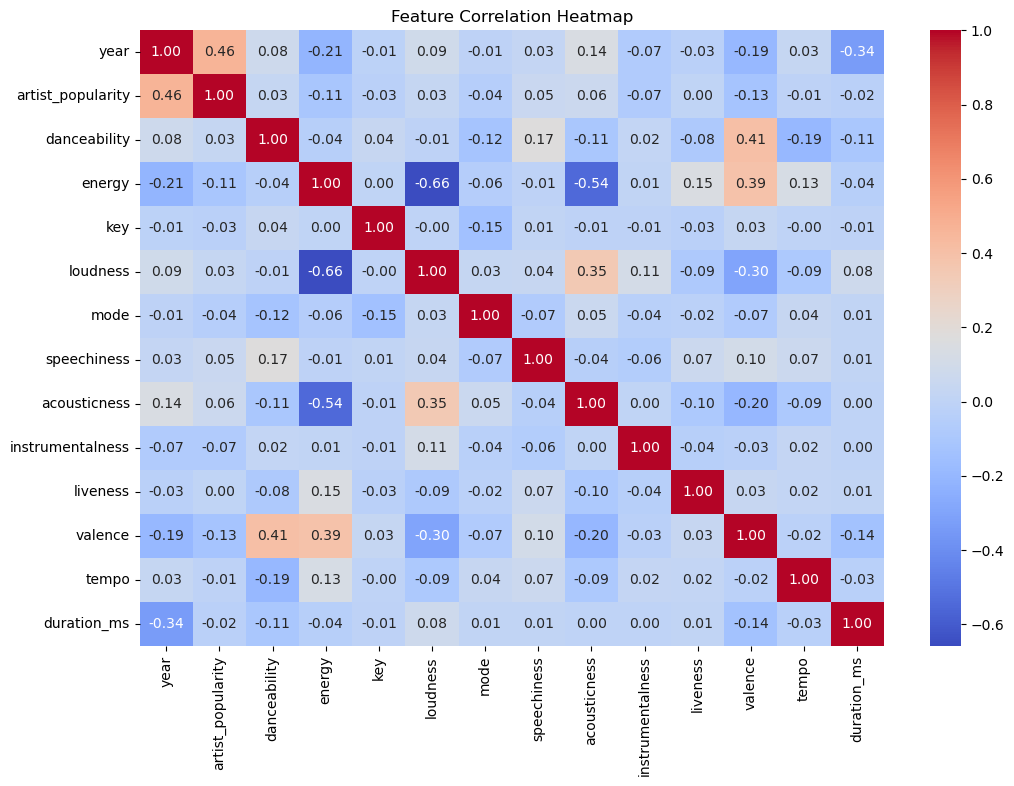

In [5]:
# Binning the 'track_popularity' variable into 2 categories
bins = [0, 70, 100]
labels = ['Not popular', 'Popular']
# spotify_data['popularity_bin'] = pd.cut(spotify_data['track_popularity'], bins=bins, labels=labels)


# Apply binning
spotify_data['popularity_bin'] = pd.cut(
    spotify_data['track_popularity'],
    bins=bins,
    labels=labels,
    include_lowest=True  # Ensures the lowest boundary is included
)

# Prepare features (X) and target (y)
# We will only select the numerical features in order to be able to calculate the correlation
X = spotify_data.drop(columns=['track_popularity', 'popularity_bin', 'track_name', 'album', 'artist_name', 'artist_genres'])
y = spotify_data['popularity_bin']

# Visualizing the target variable distribution
import seaborn as sns

sns.countplot(x=y, palette='viridis')
plt.title('Distribution of Target Variable (Popularity)')
plt.xlabel('Popularity Bin')
plt.ylabel('Count')
plt.show()

# Correlation heatmap of numerical features
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()




## Decision tree model

### Data cleaning

As part of the data cleaning, we will drop columns with null values and handle categorical columns using label encoder

In [8]:
import openpyxl

# Red data
filename = path_to_file
spotify_data_dt = pd.read_excel(filename, 0) #it has two sheets, we load the 2nd one
spotify_data_dt.head()

# Drop rows with null values
spotify_data_dt = spotify_data_dt.dropna()

# Verify if null values are removed
spotify_data_dt.isnull().sum()

year                 0
track_name           0
track_popularity     0
album                0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
dtype: int64

In [9]:
# Identify categorical columns
categorical_columns = spotify_data_dt.select_dtypes(include=['object', 'category']).columns

# Display the categorical columns
print("Categorical columns:", categorical_columns)

#Handling categorical columns:

from sklearn.preprocessing import LabelEncoder

# Ensure uniform data types in categorical columns
for col in categorical_columns:
    spotify_data_dt[col] = spotify_data_dt[col].astype(str)

# Initialize a LabelEncoder
label_encoders = {}

# Encode categorical columns
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    spotify_data_dt[col] = label_encoders[col].fit_transform(spotify_data_dt[col])

# Verify the transformed data
spotify_data_dt.head()

Categorical columns: Index(['track_name', 'album', 'artist_name', 'artist_genres'], dtype='object')


,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2000,2039,91,1016,162,619,86,0.429,0.661,11.0,85.0,1.0,0.0281,0.00239,0.000121,0.2340,0.285,173.372,266773.0
1,2000,75,84,421,884,57,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.01030,0.000000,0.6120,0.684,148.726,167067.0
2,2000,249,69,217,255,267,61,0.529,0.496,7.0,95.0,1.0,0.0290,0.17300,0.000000,0.2510,0.278,136.859,250547.0
3,2000,872,88,633,480,60,83,0.556,0.864,3.0,76.0,0.0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,216880.0
4,2000,272,74,966,0,175,65,0.610,0.926,8.0,68.0,0.0,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400.0


In [10]:
# Define bins and labels for 2 categories
bins = [0, 70, 100]  # 0-70 as "Not Popular" and 71-100 as "Popular"
labels = ['Not Popular', 'Popular']

# Apply binning
spotify_data_dt['popularity_bin'] = pd.cut(
    spotify_data_dt['track_popularity'],
    bins=bins,
    labels=labels,
    include_lowest=True  # Ensures the lowest boundary is included
)

# Verify the distribution
print(spotify_data_dt['popularity_bin'].value_counts())

popularity_bin
Popular        1334
Not Popular     965
Name: count, dtype: int64


In [11]:
spotify_data_dt['popularity_bin'] = pd.cut(
    spotify_data_dt['track_popularity'],
    bins=bins,
    labels=labels,
    include_lowest=True  # Ensures values at the lowest boundary are included
)

In [12]:
from collections import Counter

# Define a function to calculate class percentages
def class_perc(data):
    total_records = len(data)
    class_counts = Counter(data)

    for cls, count in class_counts.items():
        percentage = (count / total_records) * 100
        print(f"Class '{cls}': {percentage:.2f}%")

# Apply the function to the 'popularity_bin' column
class_perc(spotify_data_dt['popularity_bin'])

Class 'Popular': 58.03%
Class 'Not Popular': 41.97%


### Creation of 1st the model

The first step is to divide the data into training and testing, a testing size of 20% has been used. Also, the division has been done using the stratify option to balance the 2 classes of the target variable.

In [14]:
def split_df(dataframe, seed=None, percentage=0.8):
    # Features (X) and target (y)
    X_dt = dataframe.loc[:, (dataframe.columns != 'popularity_bin') & (dataframe.columns != 'track_popularity')]  # Exclude target
    y_dt = dataframe['popularity_bin']  # Use the binned target column

    # Split the data with stratification
    return train_test_split(X_dt, y_dt, test_size=1-percentage, random_state=seed, stratify=y_dt)

# Split the data
X_train_dt, X_test_dt, Y_train_dt, Y_test_dt = split_df(spotify_data_dt, seed=42, percentage=0.5)

# Verify the distribution in training and testing sets
print("Training set distribution:\n", Y_train_dt.value_counts(normalize=True))
print("\nTesting set distribution:\n", Y_test_dt.value_counts(normalize=True))


Training set distribution:
 popularity_bin
Popular        0.580505
Not Popular    0.419495
Name: proportion, dtype: float64

Testing set distribution:
 popularity_bin
Popular        0.58
Not Popular    0.42
Name: proportion, dtype: float64


In [15]:
from collections import Counter

# Define a function to calculate class percentages
def class_perc(data):
    total_records = len(data)
    class_counts = Counter(data)

    for cls, count in class_counts.items():
        percentage = (count / total_records) * 100
        print(f"Class '{cls}': {percentage:.2f}%")


In [16]:
print("Training data set: ", X_train_dt.shape)
print("Testing data set: ", X_test_dt.shape)
class_perc(Y_train_dt.to_frame(name='popularity_bin')["popularity_bin"])
class_perc(Y_test_dt.to_frame(name='popularity_bin')["popularity_bin"])

Training data set:  (1149, 18)
Testing data set:  (1150, 18)
Class 'Not Popular': 41.95%
Class 'Popular': 58.05%
Class 'Popular': 58.00%
Class 'Not Popular': 42.00%


In [17]:
from sklearn.tree import DecisionTreeClassifier

popularity_tree = DecisionTreeClassifier(random_state=42)
popularity_tree.fit(X_train_dt, Y_train_dt)

DecisionTreeClassifier(random_state=42)

Let's take a look to the performance of the classifier (by using initially Accuracy)

In [19]:
from sklearn.metrics import mean_squared_error
predictions_dt = popularity_tree.predict(X_test_dt)
print("Accuracy = {0:.4f}".format(accuracy_score(Y_test_dt, predictions_dt)))

Accuracy = 0.6452


Now we will take a look to the tree itself. This is a bit complex since sklearn does not provide a way to visualize the models. To that end, we will need to make use of an external library: `pydotplus`.

In [21]:
! pip install pydotplus

# ! pip install graphviz
# you may need to install this library directly from https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# and then uncomment following two lines
#import os
#os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'(installation folder)

from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

def plot_tree(tree, feature_names):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, feature_names=feature_names,
                    filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

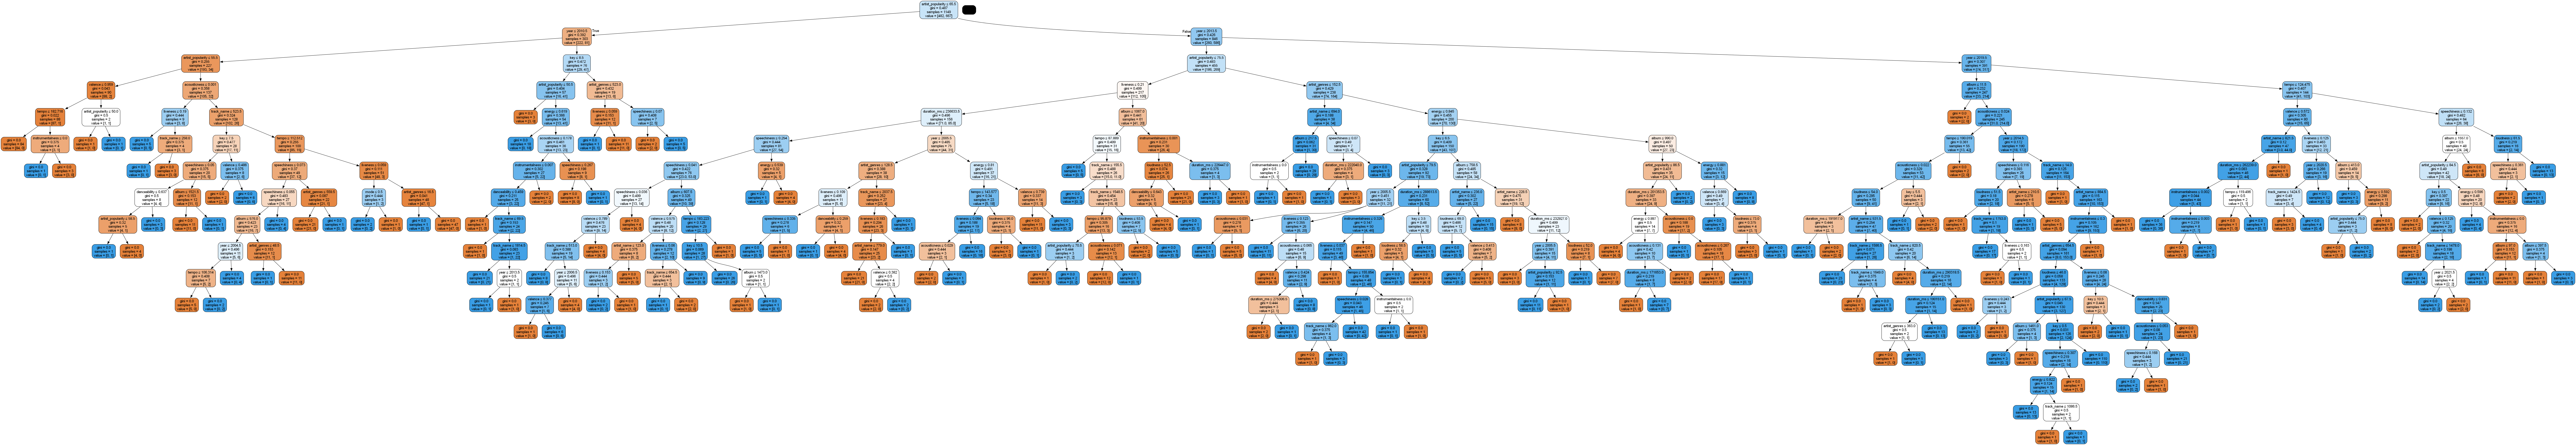

In [22]:
plot_tree(popularity_tree, X_train_dt.columns)

In [23]:
# How many nodes and leaves?
print("Number of nodes: ", popularity_tree.tree_.node_count)
print("Number of leaves: ", popularity_tree.get_n_leaves())

Number of nodes:  395
Number of leaves:  198


### Feature Importance Analysis

Let's check which are the features that have higher importance while building this model and how much do they contribute to the creation of it

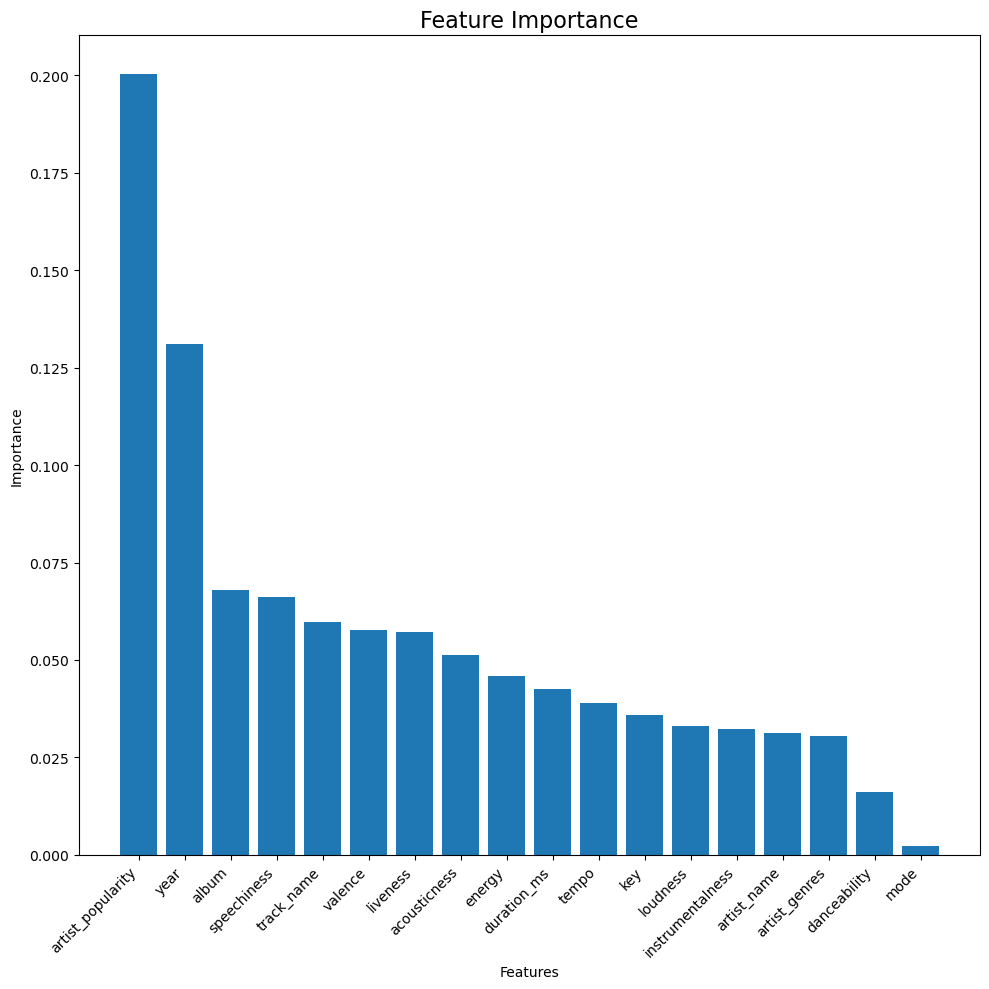

In [25]:
import numpy as np

# Sort features by importance in descending order
sorted_idx = np.argsort(popularity_tree.feature_importances_)[::-1]
sorted_features = X_train_dt.columns[sorted_idx]
sorted_importances = popularity_tree.feature_importances_[sorted_idx]

# Plot the sorted feature importances
plt.figure(figsize=(10, 10))
plt.bar(sorted_features, sorted_importances)
plt.title('Feature Importance', fontsize=16)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels and align to the right
plt.ylabel('Importance')
plt.xlabel('Features')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### Pruning the tree

Now we will prune the tree to see if we can improve performance.

There are different Pruning Parameters:

 - max_leaf_nodes: Reduce the number of leaf nodes
 - min_samples_leaf: Restrict the size of sample leaf. Minimum sample size in terminal nodes can be fixed to 30, 100, 300 or 5% of total
 - max_depth: Reduce the depth of the tree to build a generalized tree. Set the depth of the tree to 3, 5, 10 depending after verification on test data
 - etc..

Let's focus on the depth of the tree. We will test different depth thresholds via CV by using the `GridSearchCV` provided by sklearn.

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': range(1,16)} # 15 different depth levels

popularity_tree_pruned_cv = GridSearchCV(popularity_tree,
                   param_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

popularity_tree_pruned_cv.fit(X_train_dt,Y_train_dt)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=1,
             param_grid={'max_depth': range(1, 16)}, scoring='accuracy',
             verbose=1)

In [28]:
print("Best parameters set found on development set:")
print()
print(popularity_tree_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = popularity_tree_pruned_cv.cv_results_['mean_test_score']
stds = popularity_tree_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, popularity_tree_pruned_cv.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

Accuracy = 0.686 (+/0.046) for {'max_depth': 1}
Accuracy = 0.708 (+/0.045) for {'max_depth': 2}
Accuracy = 0.710 (+/0.060) for {'max_depth': 3}
Accuracy = 0.698 (+/0.053) for {'max_depth': 4}
Accuracy = 0.689 (+/0.066) for {'max_depth': 5}
Accuracy = 0.681 (+/0.056) for {'max_depth': 6}
Accuracy = 0.661 (+/0.083) for {'max_depth': 7}
Accuracy = 0.654 (+/0.054) for {'max_depth': 8}
Accuracy = 0.652 (+/0.081) for {'max_depth': 9}
Accuracy = 0.644 (+/0.060) for {'max_depth': 10}
Accuracy = 0.646 (+/0.042) for {'max_depth': 11}
Accuracy = 0.644 (+/0.065) for {'max_depth': 12}
Accuracy = 0.629 (+/0.056) for {'max_depth': 13}
Accuracy = 0.648 (+/0.061) for {'max_depth': 14}
Accuracy = 0.636 (+/0.037) for {'max_depth': 15}


Text(0, 0.5, 'Accuracy')

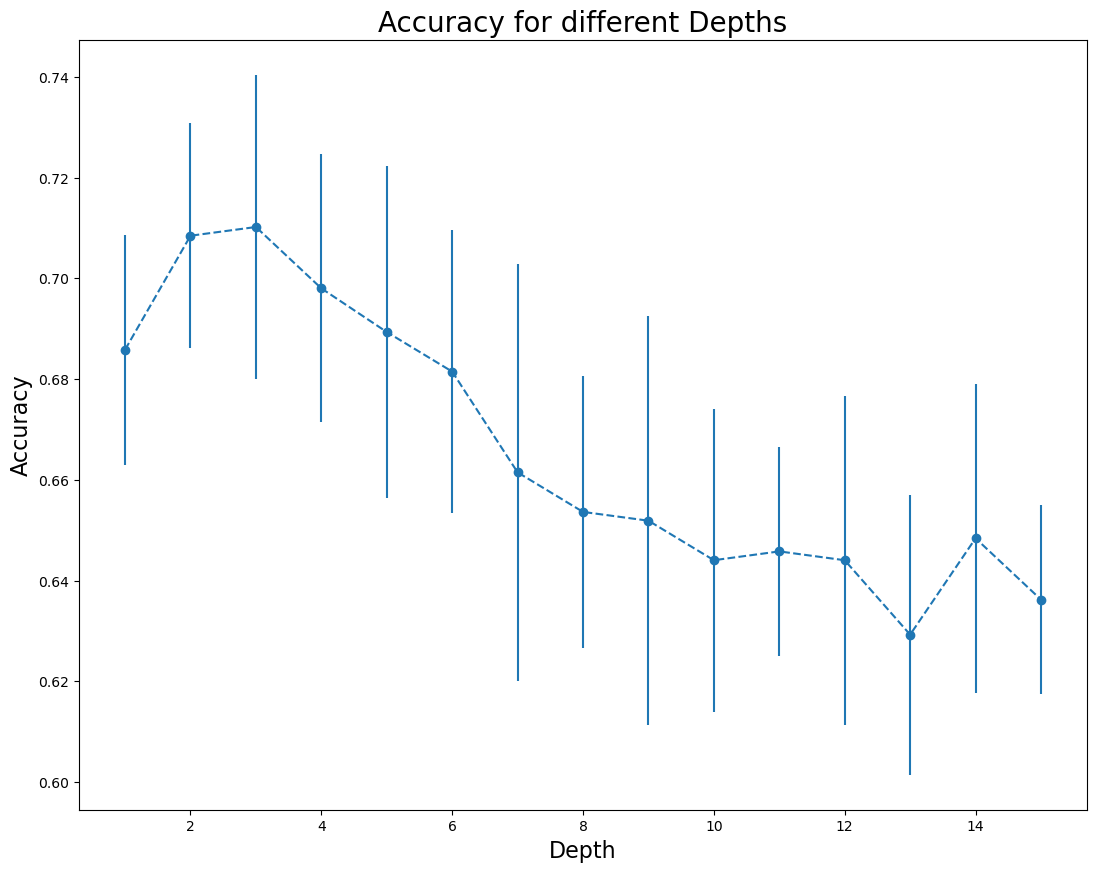

In [29]:
plt.figure(figsize=(13,10))
plt.errorbar(range(1,16,1), [m for m in means], yerr=stds, fmt='--o')
plt.title('Accuracy for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

### Test the model and predict

Let's now calculate accuracy for test data set and create some predictions out of it

In [31]:
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Train the decision tree
popularity_tree_pruned = DecisionTreeClassifier(random_state=42, max_depth=3)
popularity_tree_pruned.fit(X_train_dt, Y_train_dt)

# Generate predictions for the test set
predictions_dt = popularity_tree_pruned.predict(X_test_dt)

# Check if predictions need mapping (if numeric to string mapping is necessary)
if predictions_dt.dtype in [int, np.int32, np.int64]:
    # Map numeric predictions back to their original string labels
    predictions_dt = pd.Series(predictions_dt).map({1: 'Popular', 0: 'Not Popular'})

# Ensure Y_test is of the same type as predictions
Y_test_dt = Y_test_dt.astype(str)

# Verify the consistency of data types
print("Y_test dtype: ", Y_test_dt.dtype)
print("Predictions dtype: ", predictions_dt.dtype)

# Calculate test accuracy
accuracy = accuracy_score(Y_test_dt, predictions_dt)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(Y_test_dt, predictions_dt))

# Train Accuracy
train_predictions_dt = popularity_tree_pruned.predict(X_train_dt)

# Map train predictions if necessary
if train_predictions_dt.dtype in [int, np.int32, np.int64]:
    train_predictions_dt = pd.Series(train_predictions_dt).map({1: 'Popular', 0: 'Not Popular'})

# Ensure Y_train is consistent with predictions
Y_train_dt = Y_train_dt.astype(str)

# Calculate train accuracy
train_accuracy = accuracy_score(Y_train_dt, train_predictions_dt)
print(f"Train Accuracy: {train_accuracy:.4f}")

Y_test dtype:  object
Predictions dtype:  object
Test Accuracy: 0.6965

Classification Report:
              precision    recall  f1-score   support

 Not Popular       0.64      0.62      0.63       483
     Popular       0.73      0.75      0.74       667

    accuracy                           0.70      1150
   macro avg       0.69      0.69      0.69      1150
weighted avg       0.70      0.70      0.70      1150

Train Accuracy: 0.7311


In [32]:
# Confusion Matrix
conf_mat = confusion_matrix(Y_test_dt, predictions_dt)
TN = conf_mat[0, 0]  # True Negatives
FP = conf_mat[0, 1]  # False Positives
FN = conf_mat[1, 0]  # False Negatives
TP = conf_mat[1, 1]  # True Positives

# Calculate additional metrics
precision = precision_score(Y_test_dt, predictions_dt, pos_label='Popular')
recall = recall_score(Y_test_dt, predictions_dt, pos_label='Popular')
f1 = (2 * precision * recall) / (precision + recall)
specificity = TN / (TN + FP)

# Print additional metrics
print("\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")


Additional Metrics:
Precision: 0.7325
Recall: 0.7511
F1 Score: 0.7417
Specificity: 0.6211


Great! We have increase the accuracy with a smaller tree.

D:\Programas\Anaconda2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programas\Anaconda2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


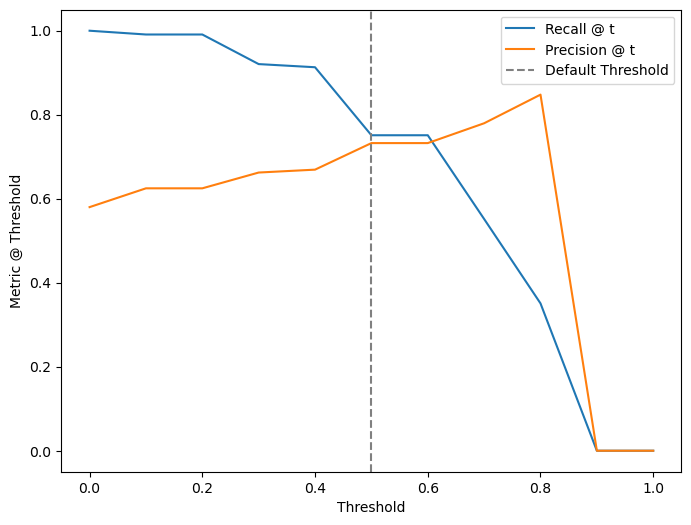

In [34]:
# Get probabilities from the model
prob_pred = popularity_tree_pruned.predict_proba(X_test_dt)[:, 1]  # Assuming binary classification

# Define thresholds
thresholds = np.arange(0.0, 1.1, 0.1)

# Compute recall and precision scores at different thresholds
recall_scores = []
precis_scores = []

for t in thresholds:
    predictions_at_t = (prob_pred >= t).astype(int)  # Convert probabilities to binary predictions at threshold t
    predictions_at_t = pd.Series(predictions_at_t).map({1: 'Popular', 0: 'Not Popular'})  # Map to labels
    recall_scores.append(recall_score(Y_test_dt, predictions_at_t, pos_label='Popular'))
    precis_scores.append(precision_score(Y_test_dt, predictions_at_t, pos_label='Popular'))

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric @ Threshold")
ax.legend()
plt.show()

Text(50.722222222222214, 0.5, 'Predicted Values')

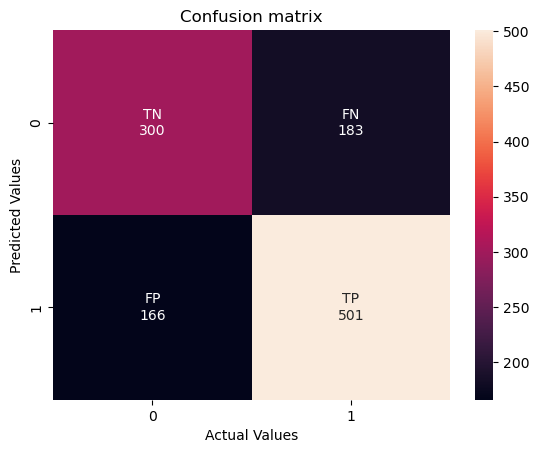

In [35]:
import seaborn as sns

conf_mat = confusion_matrix(Y_test_dt, predictions_dt)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='')
ax.set_title('Confusion matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')


Now, we represent the different values for the metrics obtained using different thresholds

In [37]:
pred = popularity_tree_pruned_cv.predict_proba(X_test_dt) > 0.3
pred

array([[False,  True],
       [ True,  True],
       [ True, False],
       ...,
       [False,  True],
       [False,  True],
       [ True,  True]])

In [38]:
# How many nodes and leaves?
print("Number of nodes: ", popularity_tree_pruned.tree_.node_count)
print("Number of leaves: ", popularity_tree_pruned.get_n_leaves())

Number of nodes:  15
Number of leaves:  8


And we can represent the set of rules

In [40]:
from sklearn import tree

text_representation = tree.export_text(popularity_tree_pruned)
print(text_representation)
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)

|--- feature_5 <= 65.50
|   |--- feature_0 <= 2010.50
|   |   |--- feature_5 <= 55.50
|   |   |   |--- class: Not Popular
|   |   |--- feature_5 >  55.50
|   |   |   |--- class: Not Popular
|   |--- feature_0 >  2010.50
|   |   |--- feature_8 <= 8.50
|   |   |   |--- class: Popular
|   |   |--- feature_8 >  8.50
|   |   |   |--- class: Not Popular
|--- feature_5 >  65.50
|   |--- feature_0 <= 2013.50
|   |   |--- feature_5 <= 75.50
|   |   |   |--- class: Not Popular
|   |   |--- feature_5 >  75.50
|   |   |   |--- class: Popular
|   |--- feature_0 >  2013.50
|   |   |--- feature_0 <= 2019.50
|   |   |   |--- class: Popular
|   |   |--- feature_0 >  2019.50
|   |   |   |--- class: Popular



### Visualization

We are going to deep down a bit more on the tree.

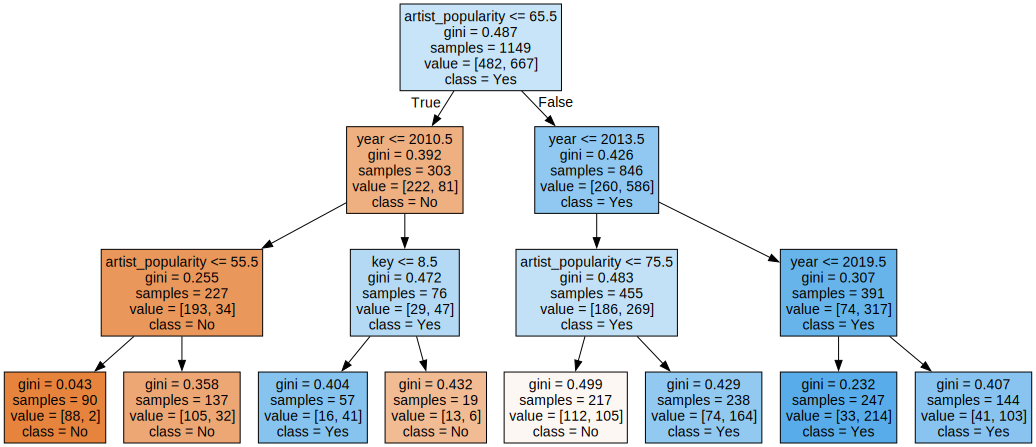

In [42]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(popularity_tree_pruned, out_file=None,
                                class_names=["No","Yes"],
                                feature_names=X_train_dt.columns,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

In [43]:
# Save it into a high resolution image
graph.render("popularity_tree_graphivz")

'popularity_tree_graphivz.png'

## Random Forest model

### Data cleaning

As part of the data cleaning, we separate the features we will use to train the model and the target variable.
We will apply one hot encoding to categorical features and drop missing values.

In [46]:
file_path = path_to_file  # Adjust this path as necessary
spotify_data_rf = pd.read_excel(file_path, sheet_name='spotify songs')

# Binning the 'track_popularity' variable into 2 categories
bins = [0, 70, 100]
labels = ['Not popular', 'Popular']
spotify_data_rf['popularity_bin'] = pd.cut(spotify_data_rf['track_popularity'], bins=bins, labels=labels)

# Prepare features (X) and target (y)
X_rf = spotify_data_rf.drop(columns=['track_popularity', 'popularity_bin', 'track_name', 'album', 'artist_name', 'artist_genres'])
y_rf = spotify_data_rf['popularity_bin']

# One-hot encode categorical features
X_rf = pd.get_dummies(X_rf, drop_first=True)

# Fill missing values
X_rf = X_rf.fillna(X_rf.mean())
y_rf = y_rf.dropna()

# Align indices of X and y
X_rf = X_rf.loc[y_rf.index]

### Creation of the model

The first step is to divide the data into training and testing, a testing size of 25% has been used. Also, the division has been done using the stratify option to balance the 2 classes of the target variable.
Afterwards, we execute a grid search with all the different parameters to find the best ones for our models.

Once we find the best parameters, we will train our model and make the predictions

In [48]:
# Split the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.25, random_state=42, stratify=y_rf)

# Updated parameter grid with further regularization
param_grid_rf = {
    'max_depth': [3, 4, 5],  # Lower max depth
    'min_samples_split': [50, 60],  # Larger splits
    'min_samples_leaf': [25, 30],  # Larger leaves
    'n_estimators': [50, 100],  # Fewer trees
    'max_features': [0.3, 0.5]  # Feature bagging
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, bootstrap=True, class_weight='balanced_subsample'),
    param_grid_rf,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search_rf.fit(X_train_rf, y_train_rf)

# Train the optimized model
best_params_rf = grid_search_rf.best_params_
print("Best Parameters:", best_params_rf)

rf_model = RandomForestClassifier(**best_params_rf, random_state=42, bootstrap=True, class_weight='balanced_subsample')
rf_model.fit(X_train_rf, y_train_rf)

# Recompute metrics
y_train_pred_rf = rf_model.predict(X_train_rf)
y_test_pred_rf = rf_model.predict(X_test_rf)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best Parameters: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 25, 'min_samples_split': 60, 'n_estimators': 100}


In the following graph, we can visually assess the best number of estimators for our model

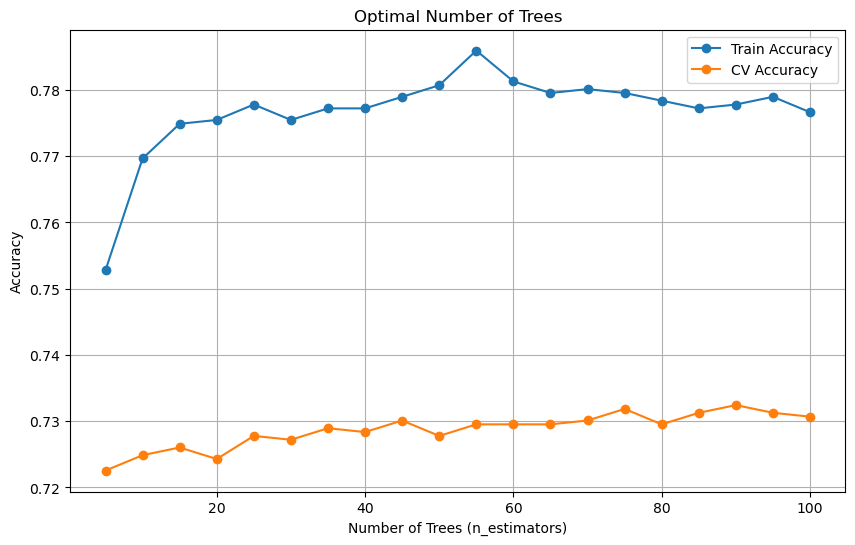

Optimal number of trees: 90


In [50]:
train_scores = []
cv_scores = []

# Define a range of trees to evaluate
estimator_range = range(5, 105, 5)  # Testing from 5 to 100 trees, in steps of 5

for n_estimators in estimator_range:
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=0.5,  # Adjust based on your current best_params
        min_samples_leaf=25,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_rf, y_train_rf)
    train_scores.append(model.score(X_train_rf, y_train_rf))
    cv_scores.append(cross_val_score(model, X_train_rf, y_train_rf, cv=5).mean())

# Plotting the train and CV accuracy
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_scores, marker='o', label="Train Accuracy")
plt.plot(estimator_range, cv_scores, marker='o', label="CV Accuracy")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Optimal Number of Trees")
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal number of trees
optimal_trees = estimator_range[np.argmax(cv_scores)]
print(f"Optimal number of trees: {optimal_trees}")


### Results

We perform a cross validation to ensure the model's robustness and generalizability.
Then, we check how good our model performs by checking the accuracy on the training and testing data, as well as, the confusion matrix and the parameters extracted from there and the ROC curve.

Train Accuracy: 0.7603257707969749
Test Accuracy: 0.6963350785340314
Cross-Validation Accuracy: 0.508 ± 0.154

Classification Report:
              precision    recall  f1-score   support

 Not popular       0.64      0.62      0.63       240
     Popular       0.73      0.75      0.74       333

    accuracy                           0.70       573
   macro avg       0.69      0.69      0.69       573
weighted avg       0.70      0.70      0.70       573


Confusion Matrix:
[[149  91]
 [ 83 250]]
Accuracy for Not popular: 0.62
Accuracy for Popular: 0.75
F1 Score Cross-Validation: 0.309 ± 0.115


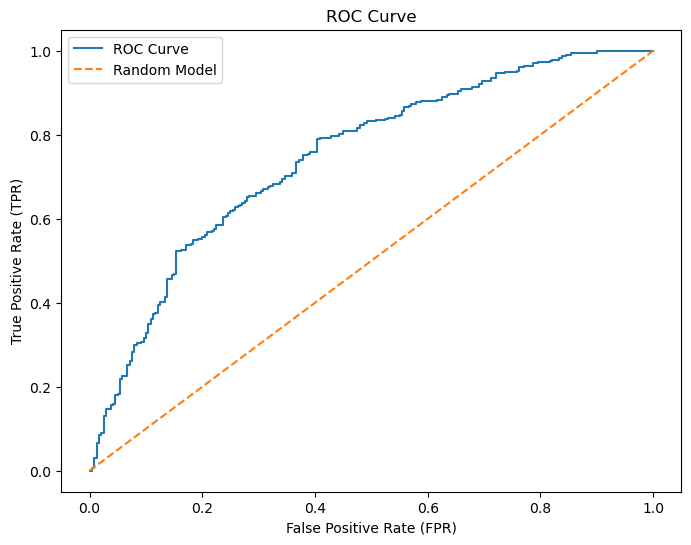

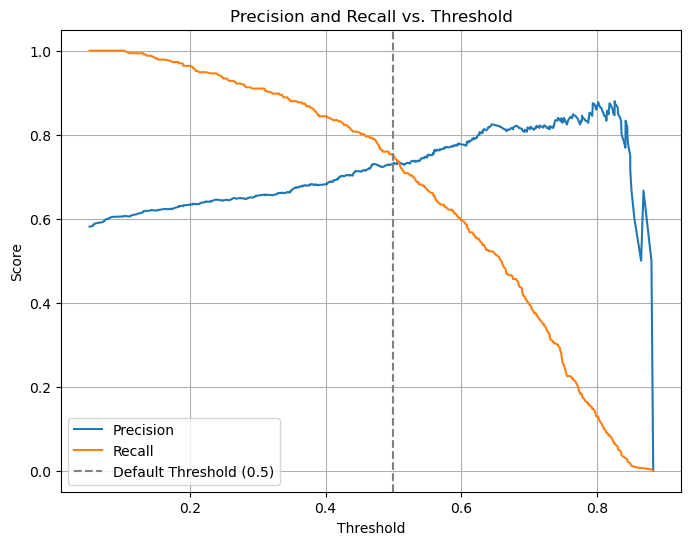

Out-of-Bag Score: 0.7265852239674229


In [52]:
train_accuracy = accuracy_score(y_train_rf, y_train_pred_rf)
test_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
cv_scores = cross_val_score(rf_model, X_rf, y_rf, cv=10, scoring='accuracy')

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Re-evaluate Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test_rf, y_test_pred_rf))
conf_matrix = confusion_matrix(y_test_rf, y_test_pred_rf)
print("\nConfusion Matrix:")
print(conf_matrix)

# Per-class accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for class_label, accuracy in zip(labels, class_accuracies):
    print(f"Accuracy for {class_label}: {accuracy:.2f}")


from sklearn.model_selection import cross_val_score

# Cross-validation with F1 score
cv_f1_scores = cross_val_score(rf_model, X_rf, y_rf, cv=5, scoring='f1_weighted')
print(f"F1 Score Cross-Validation: {cv_f1_scores.mean():.3f} ± {cv_f1_scores.std():.3f}")

from sklearn.metrics import roc_curve, auc

# Calculate probabilities for ROC curve
y_pred_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_rf.map({'Not popular': 0, 'Popular': 1}), y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_rf.map({'Not popular': 0, 'Popular': 1}), y_pred_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-recall vs threshold analysis
y_pred_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_rf.map({'Not popular': 0, 'Popular': 1}), y_pred_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()

# Random forest with out-of-bag score
rf_model_oob = RandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_split=25, min_samples_leaf=60, oob_score=True, random_state=42
)
rf_model_oob.fit(X_train_rf, y_train_rf)

print("Out-of-Bag Score:", rf_model_oob.oob_score_)



In [53]:
# Let's calculate some errors
from sklearn.metrics import mean_squared_error, r2_score

# Convert y_test and y_pred_test to numeric labels
y_test_numeric = y_test_rf.map({'Not popular': 0, 'Popular': 1})
y_pred_test_numeric = pd.Series(y_test_pred_rf).map({'Not popular': 0, 'Popular': 1})

# Predictions and Performance Metrics
mse_test = mean_squared_error(y_test_numeric, y_pred_test_numeric)
r2_test = r2_score(y_test_numeric, y_pred_test_numeric)

print("Test Mean Squared Error:", mse_test)
print("Test R² Score:", r2_test)



Test Mean Squared Error: 0.3036649214659686
Test R² Score: -0.2475225225225226


### Feature Importance Analysis

Let's check which are the features that have higher importance while building this model and how much do they contribute to the creation of it

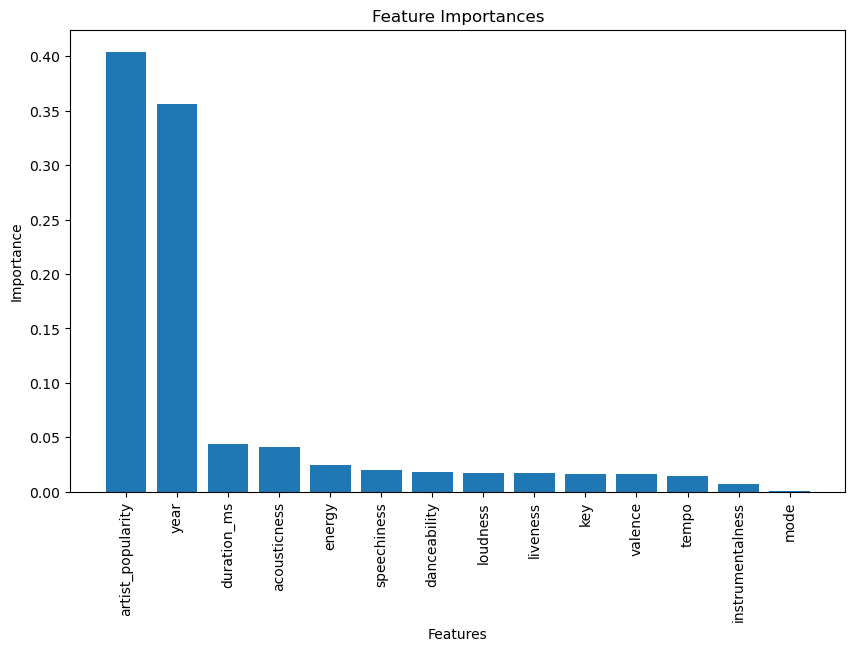

speechiness          0.224555
energy               0.109867
loudness             0.072021
danceability         0.039231
mode                -0.034258
instrumentalness    -0.057389
key                 -0.182375
liveness            -0.195759
valence             -0.228402
acousticness        -0.505963
tempo               -0.550242
duration_ms         -1.396454
artist_popularity   -5.572740
year                -6.673986
dtype: float64


In [55]:
!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti
import pandas as pd

# Feature importances
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), X.columns[sorted_indices], rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Get contributions
predictions, biases, contributions = ti.predict(rf_model, X_test_rf.values)

# Convert contributions into a DataFrame
contributions_df = pd.DataFrame(contributions[:, :, 0], columns=X_test_rf.columns)

# Summing contributions across rows
total_contributions = contributions_df.sum(axis=0)

# Displaying contributions
total_contributions.sort_values(ascending=False, inplace=True)
print(total_contributions)


D:\Programas\Anaconda2\Lib\site-packages\waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
D:\Programas\Anaconda2\Lib\site-packages\waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


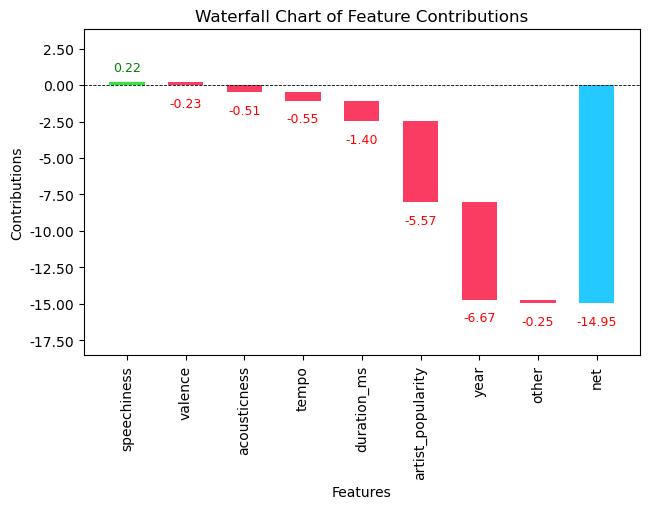

In [56]:
!pip install waterfallcharts

import waterfall_chart

import matplotlib.pyplot as plt

# Assuming `total_contributions` is already defined as a DataFrame or Series
waterfall_chart.plot(
    total_contributions.index,
    total_contributions.values,
    rotation_value=90,
    threshold=0.03,
    formatting='{:.2f}'
)

plt.title('Waterfall Chart of Feature Contributions')
plt.xlabel('Features')
plt.ylabel('Contributions')
plt.show()



## Naive Bayes Model

### Data cleaning and processing

A new copy of the dataset in order to avoid mixing and confusion has been created for this model.

The null values have been dropped and the numerical and text features have been separated in order to be able to apply difference processes to each type, according to the necessity of the model.

The data has been splitted into training and testing, using 20% of the data for testing.

Afterwards, the count vectorizer has been applied to text features and a scaling (using min max) to numerical features

In [59]:
spotify_data_nb = pd.read_excel(path_to_file)

# Binning the 'track_popularity' variable into 2 categories
bins = [0, 70, 100]
labels = ['Not popular', 'Popular']
spotify_data_nb['popularity_bin'] = pd.cut(spotify_data_nb['track_popularity'], bins=bins, labels=labels)

# Drop track popularity column
spotify_data_nb=spotify_data_nb.drop(['track_popularity'], axis=1)
spotify_data_nb

# Drop null values
spotify_data_nb=spotify_data_nb.dropna()

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# Separate the numerical features from the text features
numerical_features = spotify_data_nb[['year', 'artist_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                         'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
text_features = spotify_data_nb[['track_name', 'album', 'artist_name', 'artist_genres']]

# Convert 'artist_genres' from list to space-separated string
def join_genres(genre_list):
    return ' '.join(genre_list) if isinstance(genre_list, list) else str(genre_list)

spotify_data_nb['artist_genres'] = spotify_data_nb['artist_genres'].apply(join_genres)

# Split the data into train and test
x_train_nb, x_test_nb, y_train_nb, y_test_nb = train_test_split(
    pd.concat([numerical_features, text_features], axis=1),
    spotify_data_nb['popularity_bin'],
    test_size=0.2,
    random_state=42
)

# Initialize CountVectorizer
vectorizer = CountVectorizer(lowercase=True)

# Convert text columns to a single string for vectorization
x_train_text_nb = vectorizer.fit_transform(
    x_train_nb[['track_name', 'album', 'artist_name', 'artist_genres']].astype(str).agg(' '.join, axis=1)
)
x_test_text_nb = vectorizer.transform(
    x_test_nb[['track_name', 'album', 'artist_name', 'artist_genres']].astype(str).agg(' '.join, axis=1)
)

# Scale the numerical features AFTER splitting
scaler = MinMaxScaler()
x_train_numerical_nb = scaler.fit_transform(x_train_nb[numerical_features.columns])
x_test_numerical_nb = scaler.transform(x_test_nb[numerical_features.columns])

# Combine numerical features (scaled) and text features (sparse matrix)
x_train_combined_nb = hstack([x_train_numerical_nb, x_train_text_nb])
x_test_combined_nb = hstack([x_test_numerical_nb, x_test_text_nb])

# Verify the shape of the combined features
print(f"x_train_combined shape: {x_train_combined_nb.shape}")
print(f"x_test_combined shape: {x_test_combined_nb.shape}")


x_train_combined shape: (1832, 3788)
x_test_combined shape: (459, 3788)


### Creation of the model

We executed GridSearchCV in order to find the best parameters for our specific model. The accuracy metric has been used to compute the best parameters.

Afterwards, the model has been cross validated, train and we have used it to predict.

In [62]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_nb = {
    'alpha': [0.0, 0.5, 1.0, 2.0],  # Smoothing values
    'fit_prior': [True, False]      # Whether to learn class priors or not
}

# Initialize the model
naive_bayes = MultinomialNB()

# Perform grid search
grid_search_nb = GridSearchCV(naive_bayes, param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(x_train_combined_nb, y_train_nb)

# Best parameters and model
best_params_nb = grid_search_nb.best_params_
print("Best Parameters:", best_params_nb)
print("Best cross-validated accuracy:", grid_search_nb.best_score_)


D:\Programas\Anaconda2\Lib\site-packages\sklearn\naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
D:\Programas\Anaconda2\Lib\site-packages\sklearn\naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
D:\Programas\Anaconda2\Lib\site-packages\sklearn\naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
D:\Programas\Anaconda2\Lib\site-packages\sklearn\naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
D:\Programas\Anaconda2\Lib\site-packages\sklearn\naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
D:\Programas\Anaconda2\Lib\site-packages\sklearn\naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
 

Best Parameters: {'alpha': 2.0, 'fit_prior': False}
Best cross-validated accuracy: 0.6855943181310582


In [63]:
# Build the model
from sklearn.naive_bayes import MultinomialNB

# Train the model
naive_bayes = MultinomialNB(**best_params_nb)
naive_bayes_fit = naive_bayes.fit(x_train_combined_nb, y_train_nb)

# Make predictions
train_predict_nb = naive_bayes_fit.predict(x_train_combined_nb)
test_predict_nb= naive_bayes_fit.predict(x_test_combined_nb)


### Results

We get the train and test balanced accuracy, as well as the confusion matrix with its corresponding metrics

In [65]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

def get_scores(y_real, predict):
  ba_train = balanced_accuracy_score(y_real, predict)
  return ba_train

def print_scores(scores):
  return f"Balanced Accuracy: {scores}"

train_scores_nb = get_scores(y_train_nb, train_predict_nb)
test_scores_nb = get_scores(y_test_nb, test_predict_nb)

print("## Train Accuracy")
print(print_scores(f"{train_scores_nb:.3f}"))
print("\n## Test Accuracy")
print(print_scores(f"{test_scores_nb:.3f}"))

## Train Accuracy
Balanced Accuracy: 0.843

## Test Accuracy
Balanced Accuracy: 0.649


Text(113.9222222222222, 0.5, 'predicted label')

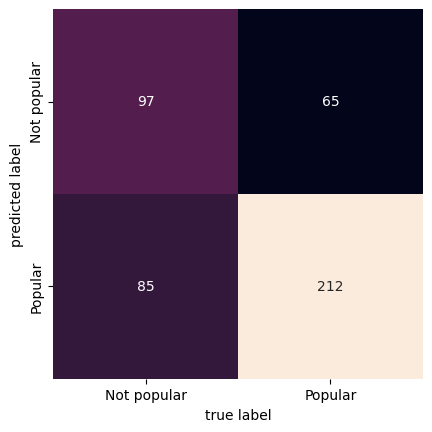

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test_nb, test_predict_nb)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=naive_bayes_fit.classes_, yticklabels=naive_bayes_fit.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Compute confusion matrix
#mat = confusion_matrix(y_test, test_predict)

# Specify the positive class (e.g., 'Popular') for binary classification
positive_class = 'Popular'

# Precision, Recall, F1 Score (Overall)
precision = precision_score(y_test_nb, test_predict_nb, pos_label=positive_class)
recall = recall_score(y_test_nb, test_predict_nb, pos_label=positive_class)
f1 = f1_score(y_test_nb, test_predict_nb, pos_label=positive_class)

# Specificity calculation
# Extract true negatives (TN) and false positives (FP) from the confusion matrix
tn, fp, fn, tp = mat.ravel()
specificity = tn / (tn + fp)

# Printing metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")

Precision: 0.71
Recall: 0.77
F1 Score: 0.74
Specificity: 0.53


## KNN

## Data cleansing and processing

In [70]:
!pip install feature_engine # Install the feature_engine package
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score

# load the data file
df_knn = pd.read_excel('Spotify_songs 2024.xlsx')

ERROR: Invalid requirement: '#'


In [71]:
# Print the shape
print(df_knn.shape)

# Print the data types
df_knn.dtypes

(2300, 19)


year                   int64
track_name            object
track_popularity       int64
album                 object
artist_name           object
artist_genres         object
artist_popularity      int64
danceability         float64
energy               float64
key                  float64
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms          float64
dtype: object

In [72]:
# Define bins and labels for track popularity
bins = [0, 70, 100]  # Adjusted bins for 2 categories: 0-70 and 71-100
labels = ['Not popular', 'polular']  # Labels for the two bins

# Create the 'Popularity Category' column using pd.cut
df_knn['target'] = pd.cut(df_knn['track_popularity'], bins=bins, labels=labels, right=True, include_lowest=True)

# Display the updated DataFrame
df_knn.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,target
0,2000,Yellow,91,Parachutes,Coldplay,['permanent wave'; 'pop'],86,0.429,0.661,11.0,85.0,1.0,0.0281,0.00239,0.000121,0.2340,0.285,173.372,266773.0,polular
1,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.01030,0.000000,0.6120,0.684,148.726,167067.0,polular
2,2000,Breathe,69,Breathe,Faith Hill,['contemporary country'; 'country'; 'country d...,61,0.529,0.496,7.0,95.0,1.0,0.0290,0.17300,0.000000,0.2510,0.278,136.859,250547.0,Not popular
3,2000,In the End,88,Hybrid Theory (Bonus Edition),Linkin Park,['alternative metal'; 'nu metal'; 'post-grunge...,83,0.556,0.864,3.0,76.0,0.0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,216880.0,polular
4,2000,Bye Bye Bye,74,No Strings Attached,*NSYNC,['boy band'; 'dance pop'; 'pop'],65,0.610,0.926,8.0,68.0,0.0,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400.0,polular


In [73]:
print ("Records and variables: ", df_knn.shape)
print ("Column names: ", df_knn.columns.to_list())

Records and variables:  (2300, 20)
Column names:  ['year', 'track_name', 'track_popularity', 'album', 'artist_name', 'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'target']


In [74]:
# Calculate the percentage of popular and not popular songs
popular_percentage = (df_knn['target'].value_counts(normalize=True) * 100).round(2)

popular_percentage

target
polular        58.0
Not popular    42.0
Name: proportion, dtype: float64

In [75]:
# Count unique values in the 'artist_genres' column
genre_counts = df_knn['artist_genres'].value_counts()

# Display the unique genre counts
genre_counts

artist_genres
['pop']                                                              135
['dance pop'; 'pop']                                                 129
['canadian hip hop'; 'canadian pop'; 'hip hop'; 'pop rap'; 'rap']     32
['dance pop'; 'pop'; 'pop rap']                                       29
['barbadian pop'; 'pop'; 'urban contemporary']                        27
                                                                    ... 
['atl hip hop'; 'dirty south rap']                                     1
['gangster rap'; 'harlem hip hop'; 'pop rap'; 'trap']                  1
['rap kreyol']                                                         1
['bass house'; 'old school bassline'; 'uk garage']                     1
['atl hip hop'; 'melodic rap'; 'rap'; 'trap']                          1
Name: count, Length: 698, dtype: int64

In [76]:
# Identify object and datetime columns
object_columns = df_knn.select_dtypes(include=['object']).columns.tolist()
datetime_columns = df_knn.select_dtypes(include=['datetime64']).columns.tolist()

# Create variables for object and datetime columns
objects = object_columns
dates = datetime_columns

print("Object columns:", objects)
print("Datetime columns:", dates)

Object columns: ['track_name', 'album', 'artist_name', 'artist_genres']
Datetime columns: []


In [77]:
# Drop object columns
df_knn = df_knn.drop(columns=objects)

# Display DataFrame
print(df_knn.head())
print ("Records and variables: ", df_knn.shape)
print ("Column names: ", df_knn.columns.to_list())

   year  track_popularity  artist_popularity  danceability  energy   key  \
0  2000                91                 86         0.429   0.661  11.0   
1  2000                84                 75         0.434   0.897   0.0   
2  2000                69                 61         0.529   0.496   7.0   
3  2000                88                 83         0.556   0.864   3.0   
4  2000                74                 65         0.610   0.926   8.0   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0      85.0   1.0       0.0281       0.00239          0.000121    0.2340   
1      69.0   1.0       0.0488       0.01030          0.000000    0.6120   
2      95.0   1.0       0.0290       0.17300          0.000000    0.2510   
3      76.0   0.0       0.0584       0.00958          0.000000    0.2090   
4      68.0   0.0       0.0479       0.03100          0.001200    0.0821   

   valence    tempo  duration_ms       target  
0    0.285  173.372     266773.0      

In [78]:
# Calculate the percentage of missing values
missing_percentage = df_knn.isnull().sum() * 100 / len(df_knn)

missing_percentage

year                 0.000000
track_popularity     0.000000
artist_popularity    0.000000
danceability         0.043478
energy               0.043478
key                  0.043478
loudness             0.043478
mode                 0.043478
speechiness          0.043478
acousticness         0.043478
instrumentalness     0.043478
liveness             0.043478
valence              0.043478
tempo                0.043478
duration_ms          0.043478
target               0.000000
dtype: float64

In [79]:
# Fill numerical columns with the mean
numerical_cols = df_knn.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df_knn[col] = df_knn[col].fillna(df_knn[col].mean())

In [80]:
# Try to apply KNN imputer, no better results that the mean with low K.
'''from sklearn.impute import KNNImputer

# Select only numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Apply KNN Imputer to the numerical columns
imputer = KNNImputer(n_neighbors=5)  # Specify the number of neighbors
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])'''

"from sklearn.impute import KNNImputer\n\n# Select only numerical columns\nnumerical_columns = df.select_dtypes(include=['float64', 'int64']).columns\n\n# Apply KNN Imputer to the numerical columns\nimputer = KNNImputer(n_neighbors=5)  # Specify the number of neighbors\ndf[numerical_columns] = imputer.fit_transform(df[numerical_columns])"

In [81]:
# Convert the imputed NumPy array back into a Pandas DataFrame
df_knn = pd.DataFrame(df_knn, columns=df_knn.columns) # This line was added

# Calculate the percentage of missing values for each column
missing_percentage2 = df_knn.isnull().sum() * 100 / len(df_knn)

# Print the result
missing_percentage2

year                 0.0
track_popularity     0.0
artist_popularity    0.0
danceability         0.0
energy               0.0
key                  0.0
loudness             0.0
mode                 0.0
speechiness          0.0
acousticness         0.0
instrumentalness     0.0
liveness             0.0
valence              0.0
tempo                0.0
duration_ms          0.0
target               0.0
dtype: float64

In [82]:
data_knn= df_knn

In [83]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the numerical features (excluding the target variable)
numerical_cols = data_knn.select_dtypes(include=np.number).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')
data_knn[numerical_cols] = scaler.fit_transform(data_knn[numerical_cols])

# Display the first few rows of the scaled data
print(data_knn.head())

   year  track_popularity  artist_popularity  danceability    energy  \
0   0.0              0.91           0.802817      0.328413  0.643121   
1   0.0              0.84           0.647887      0.334563  0.892303   
2   0.0              0.69           0.450704      0.451415  0.468905   
3   0.0              0.88           0.760563      0.484625  0.857460   
4   0.0              0.74           0.507042      0.551046  0.922923   

        key  loudness  mode  speechiness  acousticness  instrumentalness  \
0  1.000000  0.750000   1.0     0.010117      0.002431          0.000123   
1  0.000000  0.664894   1.0     0.047516      0.010519          0.000000   
2  0.636364  0.803191   1.0     0.011743      0.176881          0.000000   
3  0.272727  0.702128   0.0     0.064860      0.009782          0.000000   
4  0.727273  0.659574   0.0     0.045890      0.031685          0.001218   

   liveness   valence     tempo  duration_ms       target  
0  0.259124  0.264125  0.751488     0.286570      

In [84]:
# Drop the 'track_popularity' column
data_knn = data_knn.drop(columns=['track_popularity'])
data_knn

,year,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,target
0,0.0,0.802817,0.328413,0.643121,1.000000,0.750000,1.0,0.010117,0.002431,0.000123,0.259124,0.264125,0.751488,0.286570,polular
1,0.0,0.647887,0.334563,0.892303,0.000000,0.664894,1.0,0.047516,0.010519,0.000000,0.718978,0.690270,0.588095,0.117880,polular
2,0.0,0.450704,0.451415,0.468905,0.636364,0.803191,1.0,0.011743,0.176881,0.000000,0.279805,0.256649,0.509421,0.259118,Not popular
3,0.0,0.760563,0.484625,0.857460,0.272727,0.702128,0.0,0.064860,0.009782,0.000000,0.228710,0.386949,0.299155,0.202157,polular
4,0.0,0.507042,0.551046,0.922923,0.727273,0.659574,0.0,0.045890,0.031685,0.001218,0.074331,0.879312,0.746622,0.174275,polular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,1.0,0.802817,0.753998,0.722310,0.090909,0.776596,0.0,0.405601,0.326167,0.001178,0.128954,0.346363,0.271609,0.239627,polular
2296,1.0,0.788732,0.953260,0.782494,1.000000,0.638298,0.0,0.167118,0.046306,0.000000,0.389294,0.807754,0.304983,0.127139,Not popular
2297,1.0,0.746479,0.921279,0.550206,0.545455,0.760638,1.0,0.479675,0.388540,0.000000,0.464720,0.997864,0.530510,0.000000,polular
2298,1.0,0.774648,0.751538,0.390772,0.090909,0.648936,0.0,0.297200,0.007993,0.007036,0.131387,0.480936,0.115906,0.065770,polular


### Creation of the model

#### K5

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split # Import the train_test_split function

knn_classifier = KNeighborsClassifier(n_neighbors=5) # we don´t know yet the optimal number of neighbours

# Use train_test_split to split the data
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(data_knn.drop('target', axis=1), data_knn['target'], test_size=0.3, random_state=42)
print(X_train_knn.shape)
print(X_test_knn.shape)

knn_classifier.fit(X_train_knn, y_train_knn)

# Predictions (on test set, obviously)
knn_predictions = knn_classifier.predict(X_test_knn)

# Calculate error_rate
error_rate = 1 - accuracy_score(y_test_knn, knn_predictions)

# Imprimir la tasa de error
print("Error (k=5):", error_rate)

(1610, 14)
(690, 14)
Error (k=5): 0.33913043478260874


In [88]:
def measure_error(num_iterations, K, ratio):
    perf = np.ones(num_iterations)
    for i in range(num_iterations):
        np.random.seed(i)
        X_train_knn, X_test_knn, y_train_knn, y_test_knn = split_data(data, ratio)
        knn_classifier = KNeighborsClassifier(n_neighbors=K)
        knn_classifier.fit(X_train, y_train)
        knn_predictions = knn_classifier.predict(X_test)
        error_rate = 1 - accuracy_score(y_test, knn_predictions)
        perf[i] = error_rate
    return np.mean(perf)

ratio (train set): 0.5
Neighbours: 1 , error: 0.3783
Neighbours: 2 , error: 0.4109
Neighbours: 3 , error: 0.3563
Neighbours: 4 , error: 0.369
Neighbours: 5 , error: 0.3411
Neighbours: 6 , error: 0.3444
Neighbours: 7 , error: 0.3237
Neighbours: 8 , error: 0.3277
Neighbours: 9 , error: 0.3191
Neighbours: 10 , error: 0.3217
Neighbours: 11 , error: 0.3145
Neighbours: 12 , error: 0.3148
Neighbours: 13 , error: 0.3108
Neighbours: 14 , error: 0.3099
Mean error values for ratio 0.5: [0.3783478260869565, 0.4108695652173913, 0.3563478260869565, 0.3690434782608696, 0.3411304347826087, 0.34443478260869564, 0.32373913043478264, 0.3277391304347826, 0.31913043478260866, 0.3216521739130435, 0.3145217391304348, 0.31478260869565217, 0.3107826086956521, 0.3099130434782608]
ratio (train set): 0.6
Neighbours: 1 , error: 0.3771
Neighbours: 2 , error: 0.4098
Neighbours: 3 , error: 0.3542
Neighbours: 4 , error: 0.3634
Neighbours: 5 , error: 0.3396
Neighbours: 6 , error: 0.3452
Neighbours: 7 , error: 0.3289
Ne

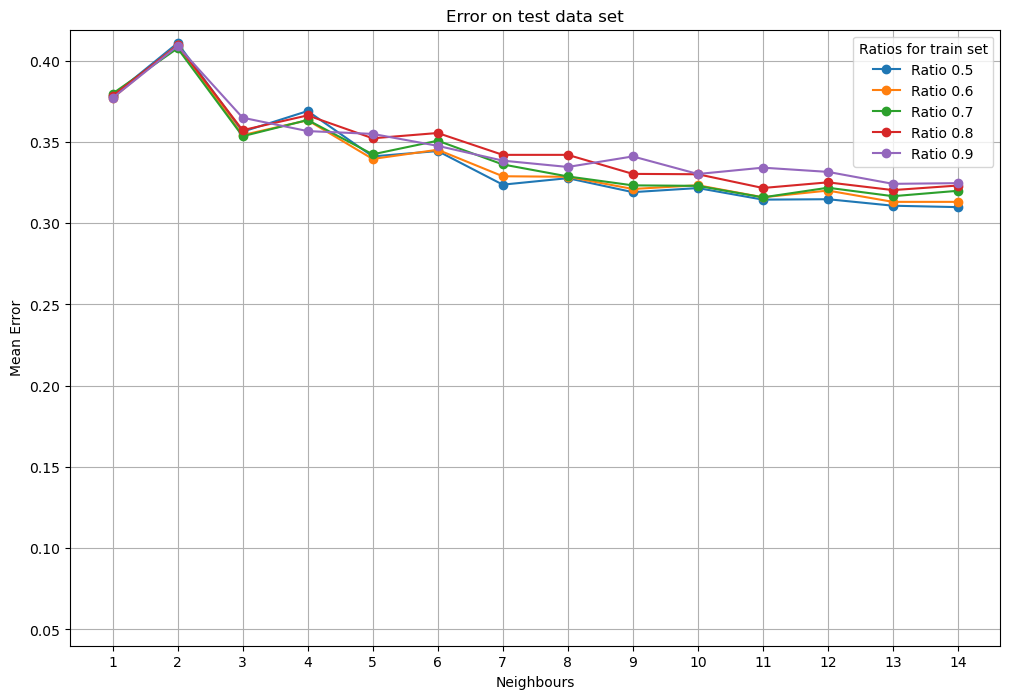

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the mean error
def measure_error(num_iterations, K, ratio):
    perf = np.ones(num_iterations)  # Array to store error rates for each iteration
    for i in range(num_iterations):
        np.random.seed(i)  # Seed for reproducibility
        # Use train_test_split instead of split_data
        X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
            data_knn.drop('target', axis=1), data_knn['target'], test_size=(1 - ratio), random_state=i
        )
        # Initialize and train KNN
        knn_classifier = KNeighborsClassifier(n_neighbors=K)
        knn_classifier.fit(X_train_knn, y_train_knn)
        # Predict on the correct test set (X_test_knn)
        knn_predictions = knn_classifier.predict(X_test_knn)
        # Calculate error rate
        error_rate = 1 - accuracy_score(y_test_knn, knn_predictions)
        perf[i] = error_rate
    return np.mean(perf)  # Return the average error rate

# Parameters for the experiment
ratios = np.arange(0.5, 1.0, 0.1)  # Train-test split ratios
k_values = np.arange(1, 15)  # Number of neighbors to test

plt.figure(figsize=(12, 8))  # Larger figure for better visualization
plt.xlabel("Neighbours")
plt.ylabel("Mean Error")

for ratio in ratios:
    print("ratio (train set):", np.round(ratio, 2))
    mean_error = []
    for K in k_values:
        error = measure_error(10, K, ratio)
        print("Neighbours:", K, ", error:", np.round(error, 4))
        mean_error.append(error)

    # Debugging: Print mean errors
    print(f"Mean error values for ratio {ratio}: {mean_error}")

    # Dynamically set y-limits
    plt.plot(k_values, mean_error, marker='o', label=f"Ratio {np.round(ratio, 2)}")

# Calculate dynamic limits if static limits don't work
plt.ylim(min(min(mean_error) if mean_error else [0.05], 0.05) - 0.01,
         max(max(mean_error) if mean_error else [0.15], 0.15) + 0.01) # Handle empty mean_error

# Finalize the plot
plt.title("Error on test data set")
plt.legend(title="Ratios for train set")
plt.xticks(k_values)
plt.grid(True)
plt.show()

#### KNN model 2 (with grid searching)

In [91]:
# Grid search

from sklearn.model_selection import GridSearchCV

parameters = {
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"] # try with both options
}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train_knn, y_train_knn)

GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [92]:
gridsearch.best_params_

{'n_neighbors': 23, 'weights': 'distance'}

Train Accuracy score:  100.0 %
Test Accuracy score:  68.84 %


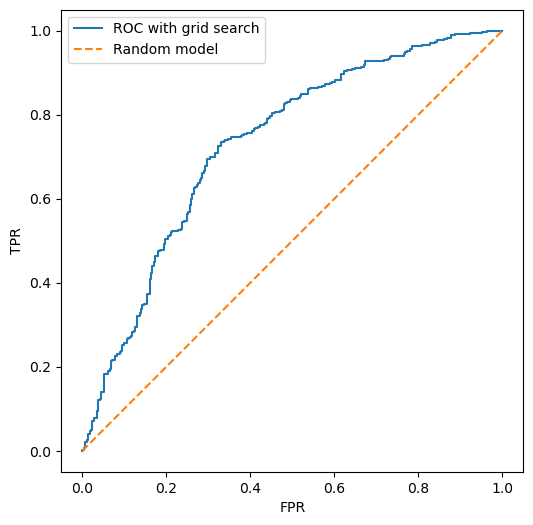

In [93]:
# Apply prediction
from sklearn.metrics import roc_auc_score, roc_curve # Import necessary functions

train_preds_grid = gridsearch.predict(X_train_knn)

predictions = gridsearch.predict(X_test_knn) #probability of being in both groups

pred_prob = gridsearch.predict_proba(X_test_knn) #probability of being in both groups

# Extract probabilities for the positive class ('polular')
prob_positive_class = pred_prob[:, 1] # Select probabilities for the second column (index 1)

quc = roc_auc_score(y_test_knn, prob_positive_class, multi_class='ovr') # Use prob_positive_class

fpr, tpr, thresholds = roc_curve(y_test_knn, prob_positive_class, pos_label='polular') # Use prob_positive_class and set pos_label

train_acc = round(gridsearch.score(X_train_knn,y_train_knn) * 100,2) #Train Accuracy score
test_acc = round(gridsearch.score(X_test_knn,y_test_knn) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

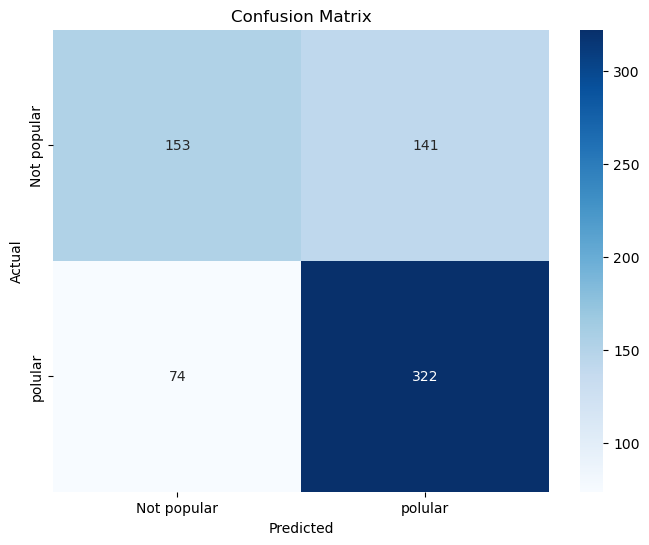

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'predictions' contains your model's predictions on the test set
cm = confusion_matrix(y_test_knn, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_knn), yticklabels=np.unique(y_test_knn))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [95]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Assuming 'predictions' contains your model's predictions on the test set and y_test is your true labels
accuracy = accuracy_score(y_test_knn, predictions)
f1 = f1_score(y_test_knn, predictions, pos_label='polular') # Specify pos_label for binary classification
precision = precision_score(y_test_knn, predictions, pos_label='polular')
recall = recall_score(y_test_knn, predictions, pos_label='polular')

# Calculate the confusion matrix
cm = confusion_matrix(y_test_knn, predictions)
tn, fp, fn, tp = cm.ravel()

# Specificity calculation
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.6884057971014492
F1 Score: 0.7497089639115251
Precision: 0.6954643628509719
Recall: 0.8131313131313131
Specificity: 0.5204081632653061
Confusion Matrix:
[[153 141]
 [ 74 322]]


In [96]:
# Assuming 'predictions' and 'y_test' are already defined from your previous code.

from sklearn.metrics import accuracy_score
import pandas as pd

# Create a DataFrame to store the results
accuracy_by_category = pd.DataFrame(columns=['Category', 'Accuracy'])

# Get unique categories
categories = y_test_knn.unique()

# Calculate accuracy for each category
for category in categories:
    # Filter predictions and true values for the current category
    # Use boolean indexing to get the correct indices
    category_indices = y_test_knn[y_test_knn == category].index

    # Get the predictions and true values using the filtered indices
    # on both y_test and predictions:
    category_predictions = predictions[y_test_knn.index.get_indexer(category_indices)]
    category_true_values = y_test_knn[category_indices]

    # Calculate accuracy for the category
    accuracy = accuracy_score(category_true_values, category_predictions)

    # Add the result to the DataFrame
    accuracy_by_category = pd.concat([accuracy_by_category, pd.DataFrame({'Category': [category], 'Accuracy': [accuracy]})], ignore_index=True)

# Display the results
accuracy_by_category

C:\Users\Marta Lacasta\AppData\Local\Temp\ipykernel_20980\2604641439.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_by_category = pd.concat([accuracy_by_category, pd.DataFrame({'Category': [category], 'Accuracy': [accuracy]})], ignore_index=True)


,Category,Accuracy
0,polular,0.813131
1,Not popular,0.520408


#### KNN Bagging

In [98]:
best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]

bagged_knn = KNeighborsClassifier( # this is the bagged model we will use
    n_neighbors=best_k, weights=best_weights
)

In [99]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(bagged_knn, n_estimators=100)
bagging_model.fit(X_train_knn, y_train_knn)

BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=23,
                                                 weights='distance'),
                  n_estimators=100)

Train Accuracy score:  100.0 %
Test Accuracy score:  69.28 %


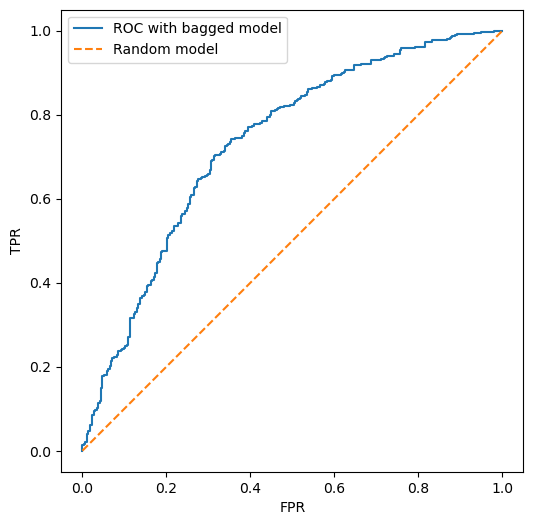

In [100]:
test_preds_grid = bagging_model.predict(X_test_knn)

predictions = bagging_model.predict(X_test_knn)
pred_prob = bagging_model.predict_proba(X_test_knn) #probability of being in both groups

# Extract probabilities for the positive class ('popular') only
prob_positive_class = pred_prob[:, 1]  # Index 1 corresponds to the 'popular' class

# Calculate AUC using probabilities for the positive class
auc = roc_auc_score(y_test_knn, prob_positive_class, multi_class='ovr')

# Update roc_curve to use probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test_knn, prob_positive_class, pos_label='polular')

train_acc = round(bagging_model.score(X_train_knn,y_train_knn) * 100,2) #Train Accuracy score
test_acc = round(bagging_model.score(X_test_knn,y_test_knn) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with bagged model")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

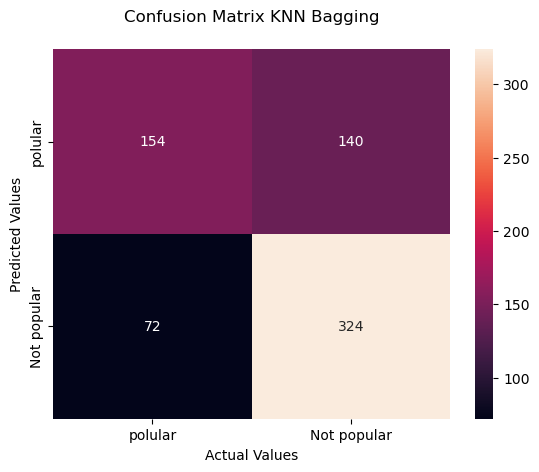

In [101]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test_knn, predictions)

fig, ax = plt.subplots()

# Get the number of classes
num_classes = conf_mat.shape[0]

# Define label names for a multi-class confusion matrix
label_names = data_knn['target'].unique()  # Get unique class names from your target variable

# Create annotations with the correct shape
labels = np.empty_like(conf_mat, dtype=object)  # Create an empty array with the same shape as conf_mat
for i in range(num_classes):
    for j in range(num_classes):
        labels[i, j] = f'{conf_mat[i, j]}'  # Add the confusion matrix values as annotations


# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='', ax=ax, xticklabels=label_names, yticklabels=label_names) # Pass ax to heatmap and label names
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')


# Add the title
plt.title('Confusion Matrix KNN Bagging', pad=20)
# Show the plot
plt.show()

In [102]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Get predictions
predictions = bagging_model.predict(X_test_knn)

# Create a DataFrame for the results
results_df = pd.DataFrame({'Actual': y_test_knn, 'Predicted': predictions})

# Calculate accuracy for each category
accuracy_by_category = results_df.groupby('Actual').apply(lambda x: accuracy_score(x['Actual'], x['Predicted']))

# Display the results in a table
accuracy_by_category

C:\Users\Marta Lacasta\AppData\Local\Temp\ipykernel_20980\713550836.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_category = results_df.groupby('Actual').apply(lambda x: accuracy_score(x['Actual'], x['Predicted']))
C:\Users\Marta Lacasta\AppData\Local\Temp\ipykernel_20980\713550836.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_category = results_df.groupby('Actual').apply(lambda x: accuracy_score(x['Actual'], x['Predicted']))


Actual
Not popular    0.523810
polular        0.818182
dtype: float64

In [103]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# Predictions on the test set
predictions = bagging_model.predict(X_test_knn)

# Probabilities for the positive class ('popular')
pred_prob = bagging_model.predict_proba(X_test_knn)
prob_positive_class = pred_prob[:, 1]


# Calculate metrics
accuracy = accuracy_score(y_test_knn, predictions)
f1 = f1_score(y_test_knn, predictions, pos_label='polular')
precision = precision_score(y_test_knn, predictions, pos_label='polular')
recall = recall_score(y_test_knn, predictions, pos_label='polular')
auc = roc_auc_score(y_test_knn, prob_positive_class, multi_class='ovr')

cm = confusion_matrix(y_test_knn, predictions)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

train_predictions = bagging_model.predict(X_train_knn)
train_accuracy = accuracy_score(y_train_knn, train_predictions)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"AUC: {auc}")
print(f"Confusion Matrix:\n{cm}")

Train Accuracy: 1.0
Test Accuracy: 0.6927536231884058
F1 Score: 0.7534883720930232
Precision: 0.6982758620689655
Recall: 0.8181818181818182
Specificity: 0.5238095238095238
AUC: 0.7325809111523397
Confusion Matrix:
[[154 140]
 [ 72 324]]
